In [36]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pickle
from skimage.feature import hog
import re

In [37]:
# Directorio de imágenes
image_dir = "billetes/"
labels = []
features = []

In [38]:
for file in os.listdir(image_dir):
    if file.endswith(".jpg") or file.endswith(".JPG"):
        # Usamos una expresión regular para extraer el número después de 'MXN' y antes de 'N'
        match = re.search(r'MX(\d+)N', file)
        if match:
            label = int(match.group(1))  # Extraemos el número como entero
            print(f"Etiqueta extraída: {label}")  # Imprimir para verificar
        else:
            print(f"No se pudo extraer la etiqueta de: {file}")  # Si no se extrae la etiqueta, lo imprimimos
            continue
        
        img_path = os.path.join(image_dir, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))  # Redimensionar
        # Extraer características HOG
        hog_features, _ = hog(img, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True)
        features.append(hog_features)
        labels.append(label)



Etiqueta extraída: 500
Etiqueta extraída: 100
Etiqueta extraída: 200
Etiqueta extraída: 50
Etiqueta extraída: 200
Etiqueta extraída: 20
Etiqueta extraída: 200
Etiqueta extraída: 50
Etiqueta extraída: 100
Etiqueta extraída: 500
Etiqueta extraída: 500
Etiqueta extraída: 20
Etiqueta extraída: 100
Etiqueta extraída: 500
Etiqueta extraída: 500
Etiqueta extraída: 100
Etiqueta extraída: 50
Etiqueta extraída: 200
Etiqueta extraída: 20
Etiqueta extraída: 200
Etiqueta extraída: 50
Etiqueta extraída: 200
Etiqueta extraída: 100
Etiqueta extraída: 500
Etiqueta extraída: 500
Etiqueta extraída: 100
Etiqueta extraída: 200
Etiqueta extraída: 50
Etiqueta extraída: 200
Etiqueta extraída: 20
Etiqueta extraída: 200
Etiqueta extraída: 50
Etiqueta extraída: 500
Etiqueta extraída: 500
Etiqueta extraída: 500
Etiqueta extraída: 500
Etiqueta extraída: 100
Etiqueta extraída: 50
Etiqueta extraída: 200
Etiqueta extraída: 20
Etiqueta extraída: 200
Etiqueta extraída: 50
Etiqueta extraída: 200
Etiqueta extraída: 100
E

In [39]:
# Convertir a arreglos numpy
X = np.array(features)
Y = np.array(labels)

In [40]:
# Dividir en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [41]:
# Contar las ocurrencias de cada clase en el conjunto de etiquetas
unique, counts = np.unique(Y, return_counts=True)
print("Distribución de clases:")
for u, c in zip(unique, counts):
    print(f"Denominación {u}: {c} imágenes")

Distribución de clases:
Denominación 20: 75 imágenes
Denominación 50: 80 imágenes
Denominación 100: 80 imágenes
Denominación 200: 80 imágenes
Denominación 500: 80 imágenes


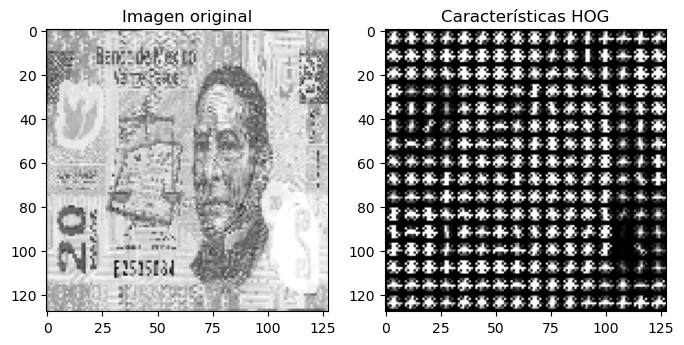

In [42]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure

# Ver algunas características HOG para una imagen
sample_image_path = os.path.join(image_dir, os.listdir(image_dir)[100])  # Usamos la primera imagen como ejemplo
img = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)
img_resized = cv2.resize(img, (128, 128))  # Redimensionar para HOG
hog_features, hog_image = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True)

# Mejorar la visualización
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Mostrar la imagen original y las características HOG
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(img_resized, cmap=plt.cm.gray)
plt.title('Imagen original')
plt.subplot(122)
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
plt.title('Características HOG')
plt.show()

In [43]:
modelo = SVC(kernel='rbf', C=10, gamma='scale')
modelo.fit(X_train, Y_train)

SVC(C=10)

In [44]:
# Guardar el modelo entrenado
with open("modelo_billetes.pkl", "wb") as archivo_modelo:
    pickle.dump(modelo, archivo_modelo)

In [45]:
# Cargar el modelo previamente guardado
with open("modelo_billetes.pkl", "rb") as archivo_modelo:
    modelo_cargado = pickle.load(archivo_modelo)

In [46]:
# Evaluar el modelo
y_pred = modelo_cargado.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report

# Matriz de confusión
cm = confusion_matrix(Y_test, y_pred)
print("Matriz de Confusión:")
print(cm)

# Reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(Y_test, y_pred))

Matriz de Confusión:
[[13  0  0  0  0]
 [ 0 16  0  0  0]
 [ 0  0 15  0  0]
 [ 0  0  0 16  0]
 [ 0  0  0  0 19]]
Reporte de clasificación:
              precision    recall  f1-score   support

          20       1.00      1.00      1.00        13
          50       1.00      1.00      1.00        16
         100       1.00      1.00      1.00        15
         200       1.00      1.00      1.00        16
         500       1.00      1.00      1.00        19

    accuracy                           1.00        79
   macro avg       1.00      1.00      1.00        79
weighted avg       1.00      1.00      1.00        79

